In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

%matplotlib inline

In [3]:
def to_long_form(df_measure_file, summary_interval, simulation_horizon, measure, number_attr=5):
    """
    df_measure_file: the raw measures dataframe read from csv
    number_attr: number of attributes, the default is [Link,Anode,Bnode,Dist,Lanes]
    summary_interval: the length of simulation interval in minutes
    simulation_horizon: the length of simulation horizon in minutes
    measure: the name of the measure
    """
    
    number_intervals = int(simulation_horizon / summary_interval)
    columns = df_measure_file.columns.tolist()
    intervals_in_file = columns[number_attr:]
    
    if len(intervals_in_file) != number_intervals:
        raise Exception("The specified number of intervals {:d} != number of intervals {:d} in the input data".format(number_intervals,len(intervals_in_file)))
    
    id_vars = df_measure_file.columns.tolist()[:5]
    value_vars = df_measure_file.columns.tolist()[5:]
    df_clean = pd.melt(df_measure_file, id_vars=id_vars, value_vars=value_vars, var_name='Interval', value_name=measure)
    
    # cast interval to integer
    df_clean['Interval'] = df_clean.Interval.astype(int)
    
    # add string time stamps
    stamps = pd.date_range('1/1/2011', periods=number_intervals, freq='15Min').strftime('%H:%M:%S').values
    stamps_dict = {i:stamp for i, stamp in zip(range(1, number_intervals+1), stamps)}
    df_clean['TimeStamp'] = df_clean.Interval.map(stamps_dict)
    return df_clean

In [4]:
def compare_profiles(dfs, nodes, names, title, simulation_interval, measure_name):
    if len(dfs) != len(nodes) or len(dfs) != len(names) or len(nodes) != len(names):
        raise Exception('Data inconsistency data = {:d}, nodes = {:d}, names = {:d}'.format((len(dfs), len(nodes), len(names))))
    
    colors = 'gbmr'                                                                                        
    
    measures = []
    end_interval = int(24 * 60 / simulation_interval)
    selection_columns = ['Link', 'Interval', 'TimeStamp'] + [measure_name]
    for i, (df, node, name) in enumerate(zip(dfs, nodes, names)):                                                                                   
        anode, bnode = node
        measure = df.loc[(df.Anode == anode) & (df.Bnode == bnode) & (df.Interval <= end_interval), selection_columns]
        print('Number of observations for Measure {:d} = {:d}'.format(i, len(measure)))
        x, y, xlabels = measure.Interval.values, measure[measure_name].values, measure.TimeStamp.values
        measures.append((x, y, xlabels, name))
    
    
    xticks = np.arange(0, end_interval, int(60/simulation_interval))
    xticklabels = measures[0][2][xticks]
    
    fig, ax = plt.subplots(figsize=(16,8));
    for i, (measure, color) in enumerate(zip(measures, colors)):                                                                                    
        ax.plot(measure[0], measure[1], color+'-', label=measure[3]);
    
    ax.set_ylabel(measure_name);
    ax.set_xticks(ticks=xticks)
    ax.set_xticklabels(xticklabels, rotation='vertical')
    ax.set_title(title)
    ax.legend()
    
    return ax

### Process DynusT File

In [21]:
DYNUST_DATA_FOLDER = r'Q:\Houston_8_County_DTA_CalibValid\_rpt'
DynusT_file = 'OutFlow_HGAC_17_Pr_full.csv'
DynusT_file = os.path.join(DYNUST_DATA_FOLDER, DynusT_file)
DynusT_file

'Q:\\Houston_8_County_DTA_CalibValid\\_rpt\\OutFlow_HGAC_17_Pr_full.csv'

In [18]:
simulation_horizon, simulation_interval = 1620, 15
number_intervals = int(simulation_horizon / simulation_interval)
measure_name = 'Flow'

In [19]:
df_DynusT_file = pd.read_csv(DynusT_file)
df_DynusT_file = df_DynusT_file.drop(df_DynusT_file.columns[-1], axis=1)
df_DynusT_file.head()

,Link,Anode,Bnode,Dist,Lanes,1,2,3,4,5,...,99,100,101,102,103,104,105,106,107,108
0,1,6001,6063,0.161,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,6001,6080,0.855,2,1.0,7.0,6.0,16.0,13.0,...,13.0,15.0,13.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,6002,6069,0.021,2,18.0,27.0,24.0,22.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,6002,6074,2.865,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,6003,419660,1.110,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_DynusT = to_long_form(df_DynusT_file, summary_interval=simulation_interval, simulation_horizon=simulation_horizon, measure=measure_name)
df_DynusT.head()

,Link,Anode,Bnode,Dist,Lanes,Interval,Flow,TimeStamp
0,1,6001,6063,0.161,2,1,0.0,00:00:00
1,2,6001,6080,0.855,2,1,1.0,00:00:00
2,3,6002,6069,0.021,2,1,18.0,00:00:00
3,4,6002,6074,2.865,2,1,0.0,00:00:00
4,5,6003,419660,1.110,2,1,0.0,00:00:00


In [29]:
df_DynusT['UID'] = df_DynusT.Anode.apply(str) + '_' + df_DynusT.Bnode.apply(str)

In [33]:
df_DynusT_daily_flow = df_DynusT.groupby('UID', as_index=False)['Flow'].sum().sort_values(by='UID')
df_DynusT_daily_flow.head()

,UID,Flow
0,100020_100021,2215.0
1,100020_72421,157.0
2,100021_278317,2219.0
3,100021_68783,627.0
4,100024_100025,2.0


### Process TRANSIMS Link Data

In [22]:
TRANSIMS_DATA_FOLDER = r'I:\SWIFT\DynusTPrep\Results'
TRANSIMS_file = 'LinkDir_Enter.csv'
TRANSIMS_file = os.path.join(TRANSIMS_DATA_FOLDER, TRANSIMS_file)
TRANSIMS_file

'I:\\SWIFT\\DynusTPrep\\Results\\LinkData_Enter.csv'

In [34]:
df_TRANSIMS_file = pd.read_csv(TRANSIMS_file)
df_TRANSIMS_file.head()

,LINK,ANODE,BNODE,LINK.1,ANODE.1,BNODE.1,AB_000_2400,BA_000_2400
0,0,6001,6063,0,0,0,7,0
1,1,6001,6080,0,0,0,20542,0
2,2,6002,6069,0,0,0,7111,0
3,4,6003,419660,0,0,0,1719,0
4,5,6004,6031,0,0,0,235,0


In [35]:
df_TRANSIMS_file['UID'] = df_TRANSIMS_file.ANODE.apply(str) + '_' + df_TRANSIMS_file.BNODE.apply(str)

In [36]:
df_TRANSIMS_daily_flow = df_TRANSIMS_file.groupby('UID', as_index=False)['AB_000_2400'].sum().sort_values(by='UID')
df_TRANSIMS_daily_flow.head()

,UID,AB_000_2400
0,100020_100021,2216
1,100020_72421,158
2,100021_278317,2220
3,100021_68783,627
4,100024_100025,2


In [38]:
df_TRANSIMS_daily_flow.shape, df_DynusT_daily_flow.shape

((45226, 2), (45700, 2))

In [39]:
df_diff = pd.merge(left=df_DynusT_daily_flow, right=df_TRANSIMS_daily_flow, left_on='UID', right_on='UID', how='outer')

#### Are all links present?

Yes. TRANSIMS ignores all links with zero volumes

In [42]:
# In TRANSIMS not in DynusT
df_diff.loc[(df_diff.Flow.isnull() == True) & (df_diff.AB_000_2400.isnull() == False)]

,UID,Flow,AB_000_2400


In [44]:
# In DynusT not in TRANSIMS; TRANSIMS ignores zero columns
df_diff.loc[(df_diff.Flow.isnull() == False) & (df_diff.AB_000_2400.isnull() == True), 'Flow'].unique()

array([0.])

#### How large are the flow differences?

In [46]:
df_diff['Flow_Diff'] = df_diff.AB_000_2400 - df_diff.Flow

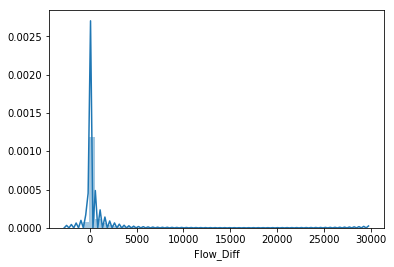

In [48]:
sns.distplot(a=df_diff[~df_diff.Flow_Diff.isnull()].Flow_Diff)

In [49]:
df_diff.Flow_Diff.describe()

count    45226.000000
mean       404.677022
std       1192.815054
min      -2672.000000
25%         -2.000000
50%          3.000000
75%        243.000000
max      29709.000000
Name: Flow_Diff, dtype: float64

In [51]:
df_diff.iloc[df_diff.Flow_Diff.idxmax()]

UID            448823_448430
Flow                       0
AB_000_2400            29709
Flow_Diff              29709
Name: 37740, dtype: object

### Compare Speed Profiles

In [112]:
speed_file_1 = r'OutLinkSpeedAll_HGAC_17_6I_full.csv'
speed_file_2 = r'OutLinkSpeedAll_HGAC_17_I9_full.csv'
speed_file_1 = os.path.join(DATA_FOLDER, speed_file_1)
speed_file_2 = os.path.join(DATA_FOLDER, speed_file_2)
speed_file_1, speed_file_2

('Q:\\Houston_8_County_DTA_CalibValid\\_rpt\\OutLinkSpeedAll_HGAC_17_6I_full.csv',
 'Q:\\Houston_8_County_DTA_CalibValid\\_rpt\\OutLinkSpeedAll_HGAC_17_I9_full.csv')

In [14]:
simulation_horizon, simulation_interval = 1620, 15
number_intervals = int(simulation_horizon / simulation_interval)
measure_name = 'Speed'

In [114]:
df_speed_file_1 = pd.read_csv(speed_file_1)
df_speed_file_1 = df_speed_file_1.drop(df_speed_file_1.columns[-1], axis=1)
df_speed_file_1.head()

,Link,Anode,Bnode,Dist,Lanes,1,2,3,4,5,...,99,100,101,102,103,104,105,106,107,108
0,1,6001,6063,0.161,2,40.0,40.0,40.00,40.00,40.00,...,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
1,2,6001,6080,0.855,2,75.0,75.0,75.00,75.00,75.00,...,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0
2,3,6002,6069,0.021,2,60.0,59.9,59.98,59.93,59.94,...,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
3,4,6002,6074,2.865,2,60.0,60.0,60.00,60.00,60.00,...,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
4,5,6003,419660,1.110,2,55.0,55.0,55.00,55.00,55.00,...,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0


In [115]:
df_speed_file_2 = pd.read_csv(speed_file_2)
df_speed_file_2 = df_speed_file_2.drop(df_speed_file_2.columns[-1], axis=1)
df_speed_file_2.head()

,Link,Anode,Bnode,Dist,Lanes,1,2,3,4,5,...,99,100,101,102,103,104,105,106,107,108
0,1,6001,6063,0.161,2,40.0,40.0,40.00,40.00,40.00,...,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
1,2,6001,6080,0.855,2,75.0,75.0,75.00,75.00,75.00,...,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0
2,3,6002,6069,0.021,2,60.0,59.9,59.98,59.93,59.93,...,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
3,4,6002,6074,2.865,2,60.0,60.0,60.00,60.00,60.00,...,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
4,5,6003,419660,1.110,2,55.0,55.0,55.00,55.00,55.00,...,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0


In [117]:
df_speed_1 = to_long_form(df_speed_file_1, summary_interval=simulation_interval, simulation_horizon=simulation_horizon, measure=measure_name)
df_speed_1.head()

,Link,Anode,Bnode,Dist,Lanes,Interval,Speed,TimeStamp
0,1,6001,6063,0.161,2,1,40.0,00:00:00
1,2,6001,6080,0.855,2,1,75.0,00:00:00
2,3,6002,6069,0.021,2,1,60.0,00:00:00
3,4,6002,6074,2.865,2,1,60.0,00:00:00
4,5,6003,419660,1.110,2,1,55.0,00:00:00


In [118]:
df_speed_2 = to_long_form(df_speed_file_2, summary_interval=simulation_interval, simulation_horizon=simulation_horizon, measure=measure)
df_speed_2.head()

,Link,Anode,Bnode,Dist,Lanes,Interval,Speed,TimeStamp
0,1,6001,6063,0.161,2,1,40.0,00:00:00
1,2,6001,6080,0.855,2,1,75.0,00:00:00
2,3,6002,6069,0.021,2,1,60.0,00:00:00
3,4,6002,6074,2.865,2,1,60.0,00:00:00
4,5,6003,419660,1.110,2,1,55.0,00:00:00


In [119]:
df_speed_1.describe()

,Link,Anode,Bnode,Dist,Lanes,Interval,Speed
count,4.935708e+06,4.935708e+06,4.935708e+06,4.935708e+06,4.935708e+06,4.935708e+06,4.935708e+06
mean,2.287646e+04,2.309323e+05,2.308298e+05,3.785675e-01,1.892541e+00,5.450000e+01,3.994560e+01
std,1.320146e+04,1.428459e+05,1.428931e+05,7.138331e-01,8.170851e-01,3.117558e+01,1.026527e+01
min,1.000000e+00,6.001000e+03,6.001000e+03,2.000000e-03,1.000000e+00,1.000000e+00,6.000000e+00
25%,1.144600e+04,8.773700e+04,8.760000e+04,3.000000e-02,1.000000e+00,2.775000e+01,3.343000e+01
50%,2.287500e+04,2.745530e+05,2.743930e+05,1.250000e-01,2.000000e+00,5.450000e+01,3.927000e+01
75%,3.431100e+04,3.349590e+05,3.349570e+05,4.460000e-01,2.000000e+00,8.125000e+01,4.488000e+01
max,4.573900e+04,4.767910e+05,4.767910e+05,1.475300e+01,7.000000e+00,1.080000e+02,7.500000e+01


In [120]:
df_speed_2.describe()

,Link,Anode,Bnode,Dist,Lanes,Interval,Speed
count,4.935708e+06,4.935708e+06,4.935708e+06,4.935708e+06,4.935708e+06,4.935708e+06,4.935708e+06
mean,2.287646e+04,2.309323e+05,2.308298e+05,3.785675e-01,1.892541e+00,5.450000e+01,4.000964e+01
std,1.320146e+04,1.428459e+05,1.428931e+05,7.138331e-01,8.170851e-01,3.117558e+01,1.018909e+01
min,1.000000e+00,6.001000e+03,6.001000e+03,2.000000e-03,1.000000e+00,1.000000e+00,6.000000e+00
25%,1.144600e+04,8.773700e+04,8.760000e+04,3.000000e-02,1.000000e+00,2.775000e+01,3.357000e+01
50%,2.287500e+04,2.745530e+05,2.743930e+05,1.250000e-01,2.000000e+00,5.450000e+01,3.934000e+01
75%,3.431100e+04,3.349590e+05,3.349570e+05,4.460000e-01,2.000000e+00,8.125000e+01,4.490000e+01
max,4.573900e+04,4.767910e+05,4.767910e+05,1.475300e+01,7.000000e+00,1.080000e+02,7.500000e+01


Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


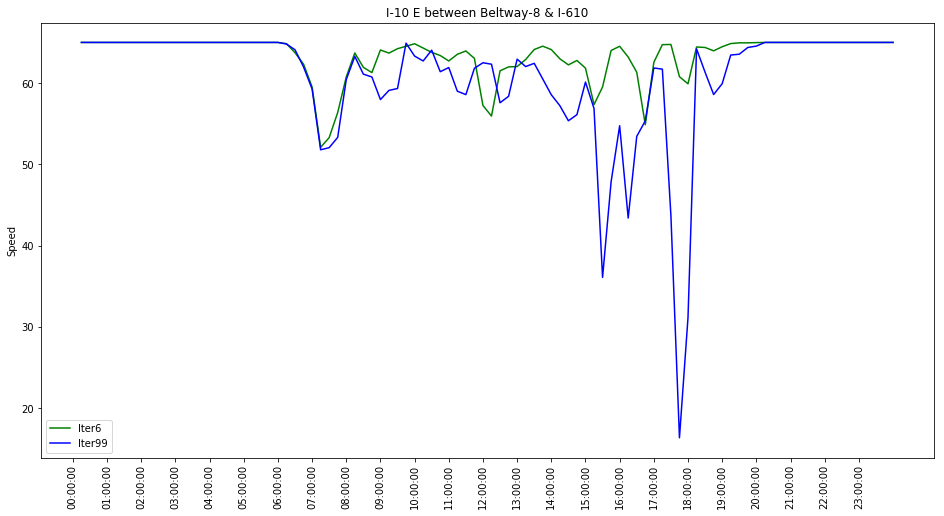

In [123]:
location = 'I-10 E between Beltway-8 & I-610'
nodes_1, nodes_2 = (63152, 91799), (63152, 91799)
name_1, name_2 = 'Iter6', 'Iter99'
compare_profiles(df_speed_1, df_speed_2,
                      nodes_1, nodes_2,
                       name_1, name_2, location, simulation_interval, measure=measure_name
                      );

Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


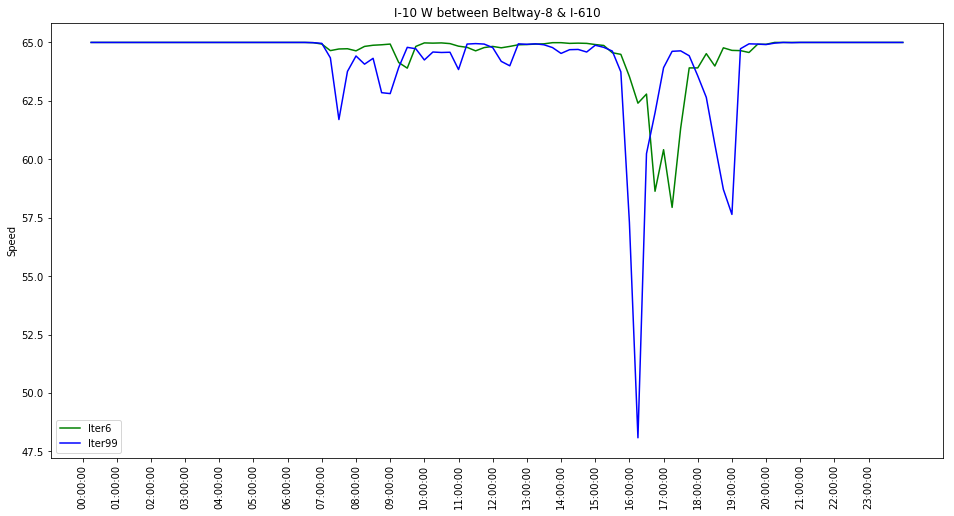

In [124]:
location = 'I-10 W between Beltway-8 & I-610'
nodes_1, nodes_2 = (23588, 183014), (23588, 183014)
name_1, name_2 = 'Iter6', 'Iter99'
compare_profiles(df_speed_1, df_speed_2,
                      nodes_1, nodes_2,
                       name_1, name_2, location, simulation_interval, measure=measure_name
                      );

Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


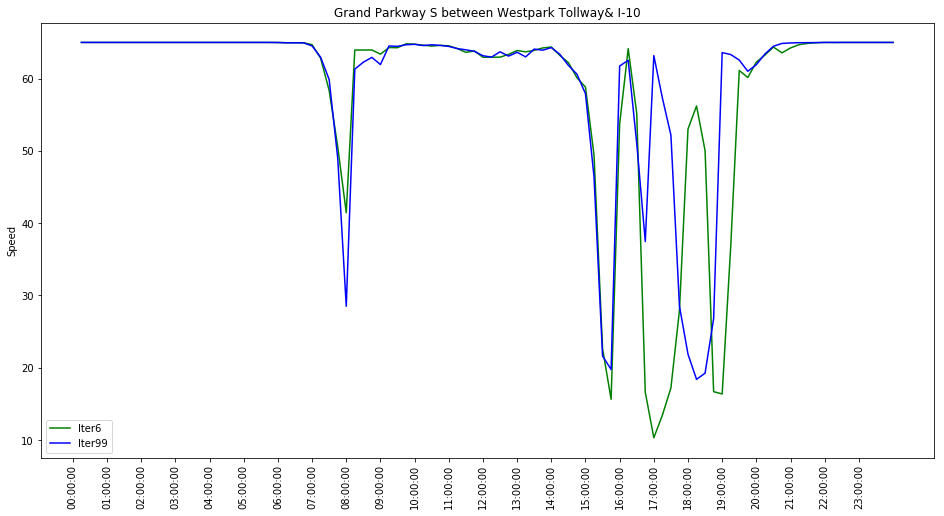

In [125]:
location = 'Grand Parkway S between Westpark Tollway& I-10'
nodes_1, nodes_2 = (281281, 382591), (281281, 382591)
name_1, name_2 = 'Iter6', 'Iter99'
compare_profiles(df_speed_1, df_speed_2,
                      nodes_1, nodes_2,
                       name_1, name_2, location, simulation_interval, measure=measure_name
                      );

Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


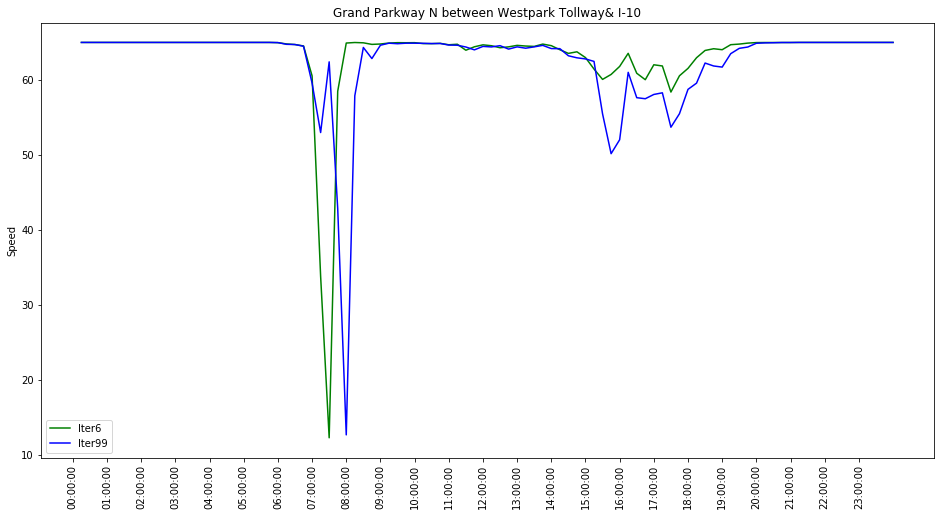

In [126]:
location = 'Grand Parkway N between Westpark Tollway& I-10'
nodes_1, nodes_2 = (349447, 362543), (349447, 362543)
name_1, name_2 = 'Iter6', 'Iter99'
compare_profiles(df_speed_1, df_speed_2,
                      nodes_1, nodes_2,
                       name_1, name_2, location, simulation_interval, measure=measure_name
                      );

Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


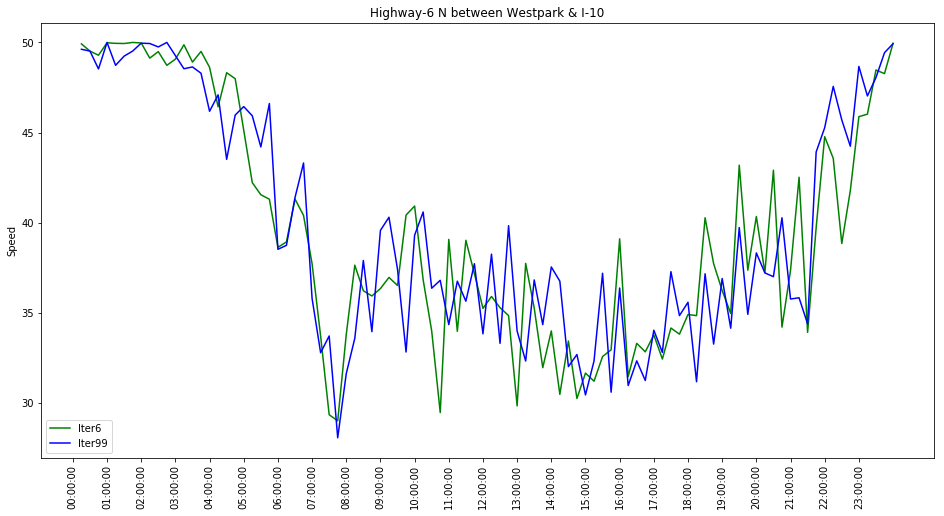

In [127]:
location = 'Highway-6 N between Westpark & I-10'
nodes_1, nodes_2 = (301019, 301020), (301019, 301020)
name_1, name_2 = 'Iter6', 'Iter99'
compare_profiles(df_speed_1, df_speed_2,
                      nodes_1, nodes_2,
                       name_1, name_2, location, simulation_interval, measure=measure_name
                      );

Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


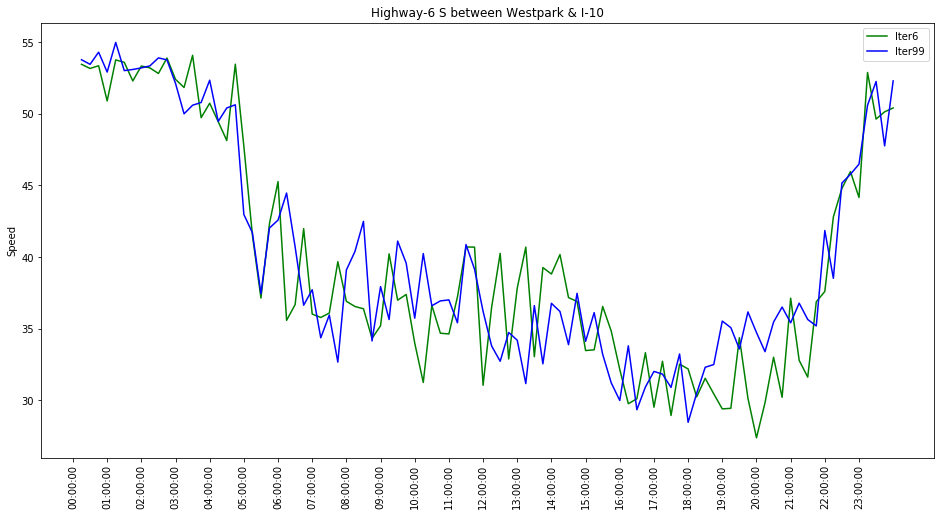

In [128]:
location = 'Highway-6 S between Westpark & I-10'
nodes_1, nodes_2 = (295701, 295694), (295701, 295694)
name_1, name_2 = 'Iter6', 'Iter99'
compare_profiles(df_speed_1, df_speed_2,
                      nodes_1, nodes_2,
                       name_1, name_2, location, simulation_interval, measure=measure_name
                      );

### Compare Volume Profiles

In [15]:
measure_name = 'Volume'

In [11]:
volume_file_1 = r'OutFlow_HGAC_17_6I_full.csv'
volume_file_2 = r'OutFlow_HGAC_17_I9_full.csv'
volume_file_3 = r'OutFlow_HGAC_17_full.csv'
volume_file_1 = os.path.join(DATA_FOLDER, volume_file_1)
volume_file_2 = os.path.join(DATA_FOLDER, volume_file_2)
volume_file_3 = os.path.join(DATA_FOLDER, volume_file_3)
volume_file_1, volume_file_2, volume_file_3

('Q:\\Houston_8_County_DTA_CalibValid\\_rpt\\OutFlow_HGAC_17_6I_full.csv',
 'Q:\\Houston_8_County_DTA_CalibValid\\_rpt\\OutFlow_HGAC_17_I9_full.csv',
 'Q:\\Houston_8_County_DTA_CalibValid\\_rpt\\OutFlow_HGAC_17_full.csv')

In [27]:
df_volume_file_1 = pd.read_csv(volume_file_1)
df_volume_file_1 = df_volume_file_1.drop(df_volume_file_1.columns[-1], axis=1)
df_volume_file_2 = pd.read_csv(volume_file_2)
df_volume_file_2 = df_volume_file_2.drop(df_volume_file_2.columns[-1], axis=1)
df_volume_file_3 = pd.read_csv(volume_file_3)
df_volume_file_3 = df_volume_file_3.drop(df_volume_file_3.columns[-1], axis=1)

In [28]:
df_volume_1 = to_long_form(df_volume_file_1, summary_interval=simulation_interval, simulation_horizon=simulation_horizon, measure=measure_name)
df_volume_2 = to_long_form(df_volume_file_2, summary_interval=simulation_interval, simulation_horizon=simulation_horizon, measure=measure_name)
df_volume_3 = to_long_form(df_volume_file_3, summary_interval=simulation_interval, simulation_horizon=simulation_horizon, measure=measure_name)

In [29]:
dfs = [df_volume_1, df_volume_2, df_volume_3]

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


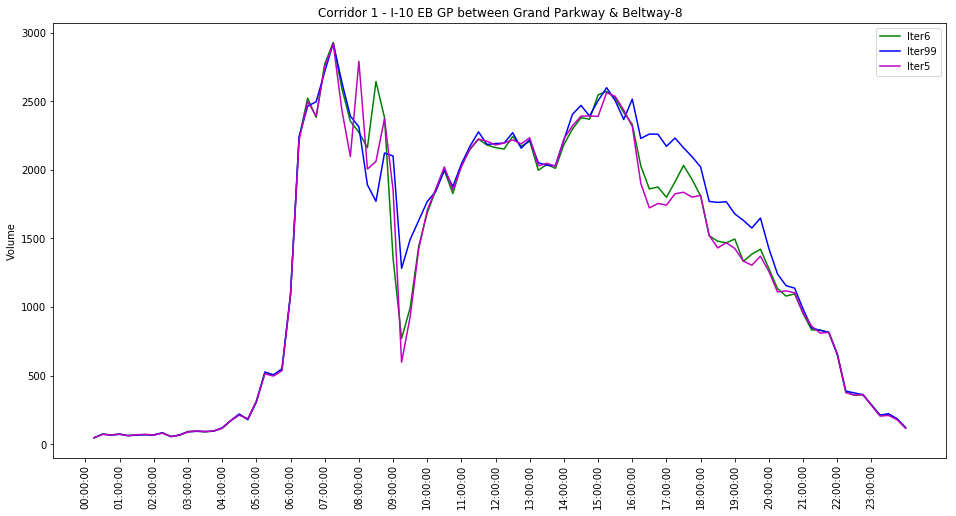

In [30]:
location = 'Corridor 1 - I-10 EB GP between Grand Parkway & Beltway-8'
nodes = [(42032, 87789), (42032, 87789), (42032, 87789)]
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


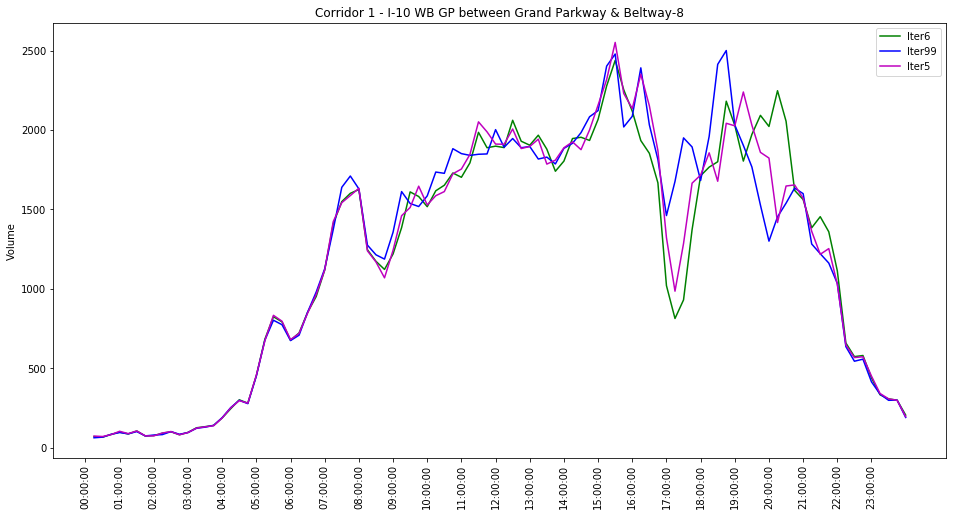

In [31]:
location = 'Corridor 1 - I-10 WB GP between Grand Parkway & Beltway-8'
nodes = [(23713, 285163)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


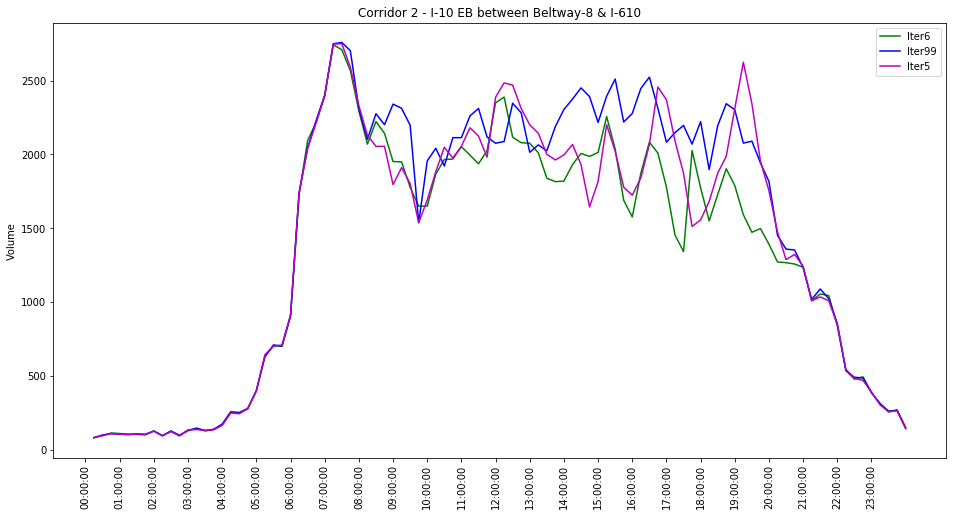

In [32]:
location = 'Corridor 2 - I-10 EB between Beltway-8 & I-610'
nodes = [(63152, 91799)] * 3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


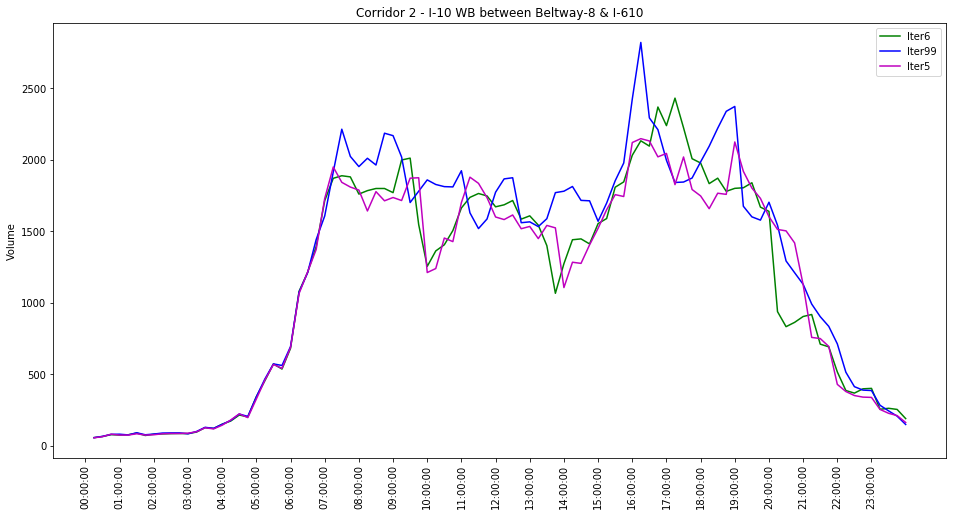

In [33]:
location = 'Corridor 2 - I-10 WB between Beltway-8 & I-610'
nodes = [(23588, 183014)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


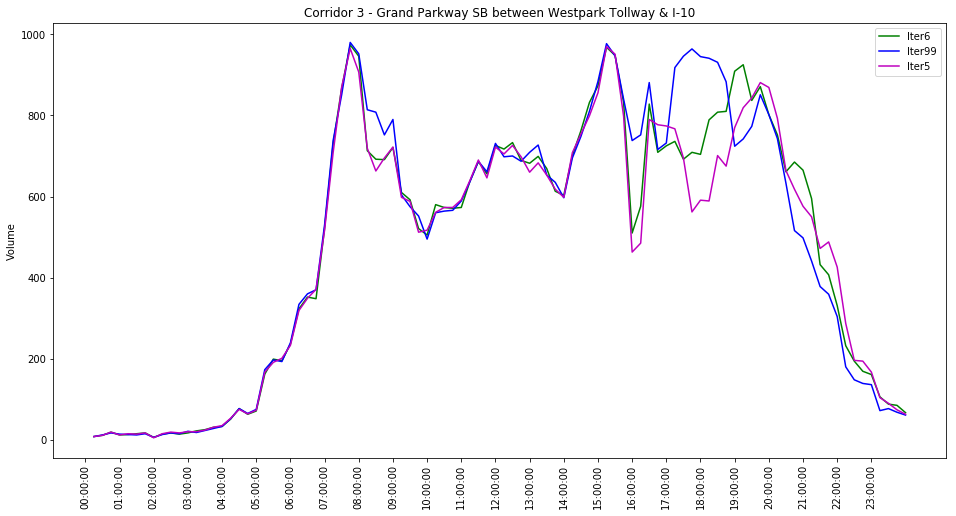

In [34]:
location = 'Corridor 3 - Grand Parkway SB between Westpark Tollway & I-10'
nodes = [(281281, 382591)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


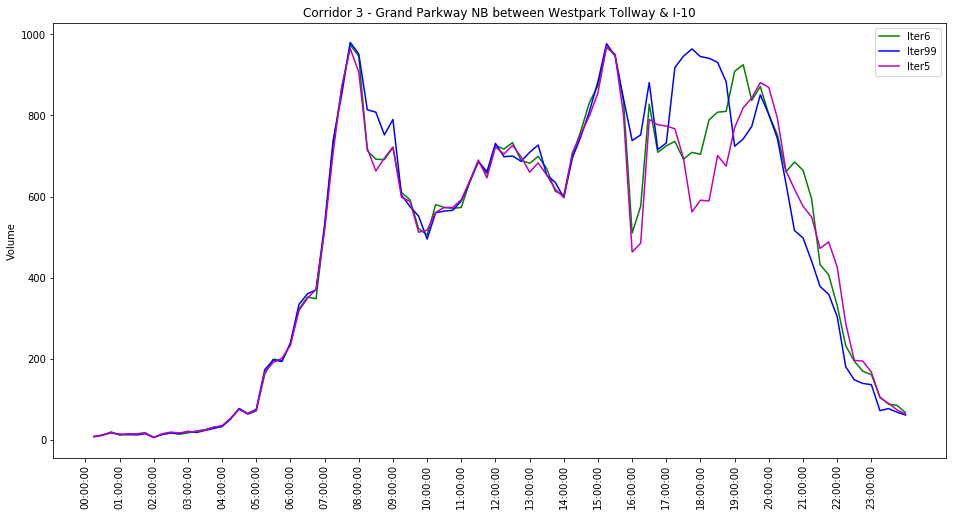

In [35]:
location = 'Corridor 3 - Grand Parkway NB between Westpark Tollway & I-10'
nodes_1, nodes_2 = (349447, 362543), (349447, 362543)
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


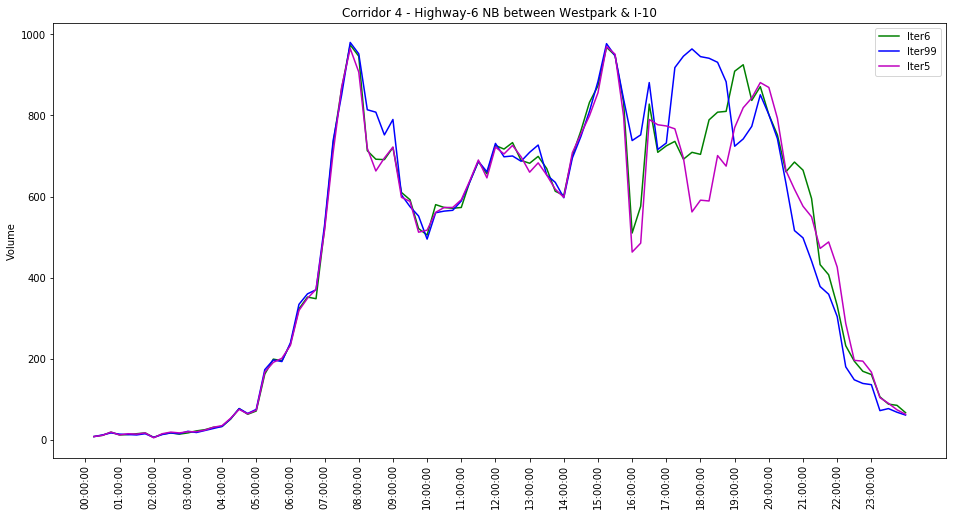

In [36]:
location = 'Corridor 4 - Highway-6 NB between Westpark & I-10'
nodes_1, nodes_2 = (301019, 301020), (301019, 301020)
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


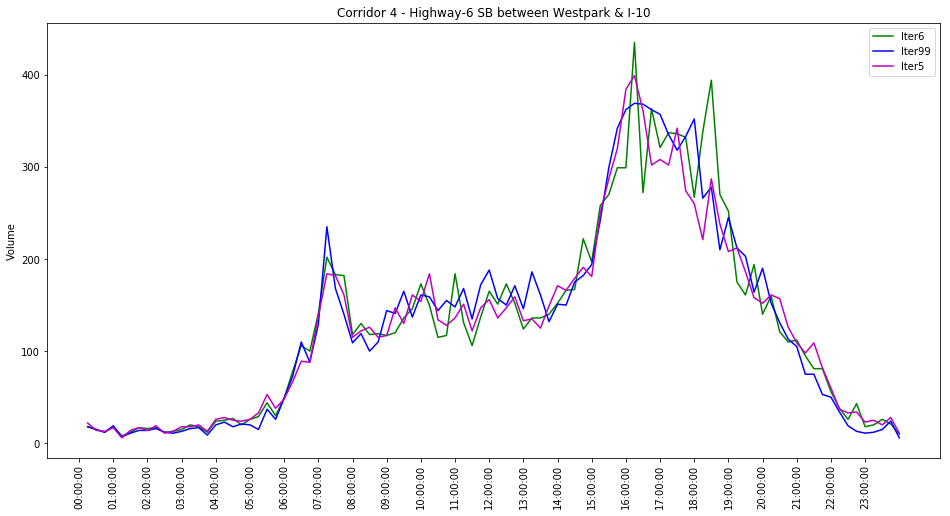

In [37]:
location = 'Corridor 4 - Highway-6 SB between Westpark & I-10'
nodes = [(295701, 295694)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


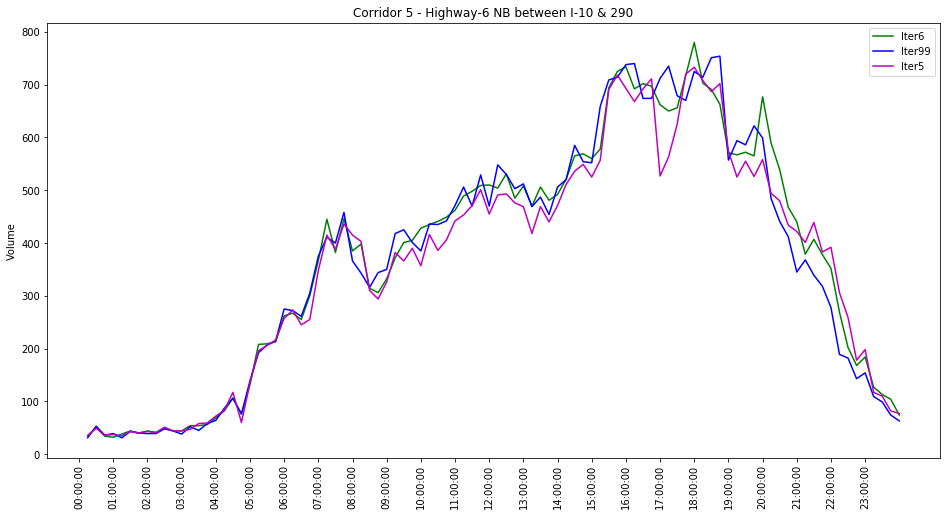

In [38]:
location = 'Corridor 5 - Highway-6 NB between I-10 & 290'
nodes = [(282196, 178769)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


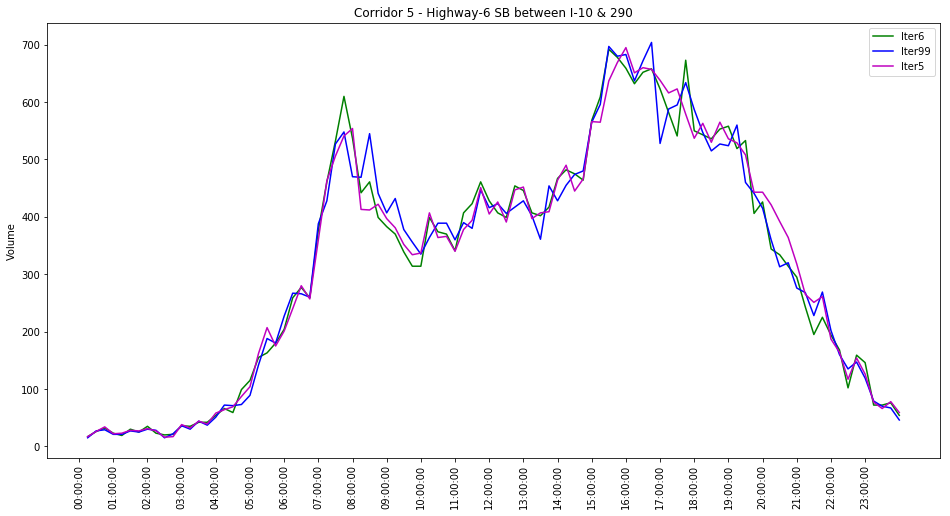

In [39]:
location = 'Corridor 5 - Highway-6 SB between I-10 & 290'
nodes = [(303515, 303516)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


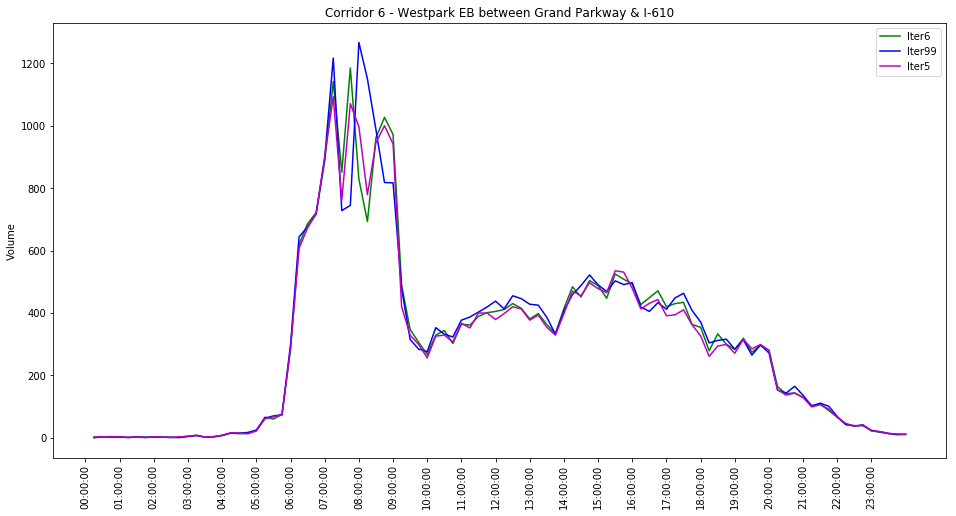

In [40]:
location = 'Corridor 6 - Westpark EB between Grand Parkway & I-610'
nodes = [(354042, 342855)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


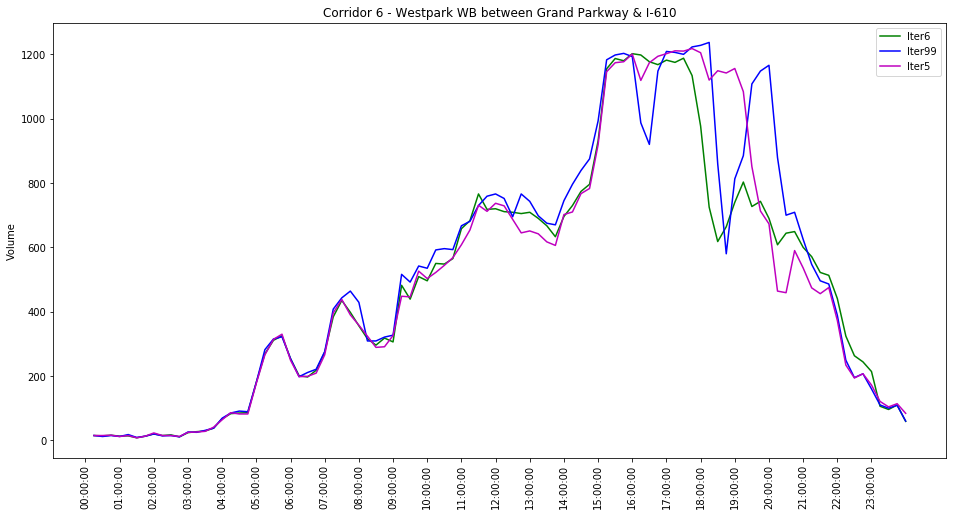

In [41]:
location = 'Corridor 6 - Westpark WB between Grand Parkway & I-610'
nodes = [(23618, 16762)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


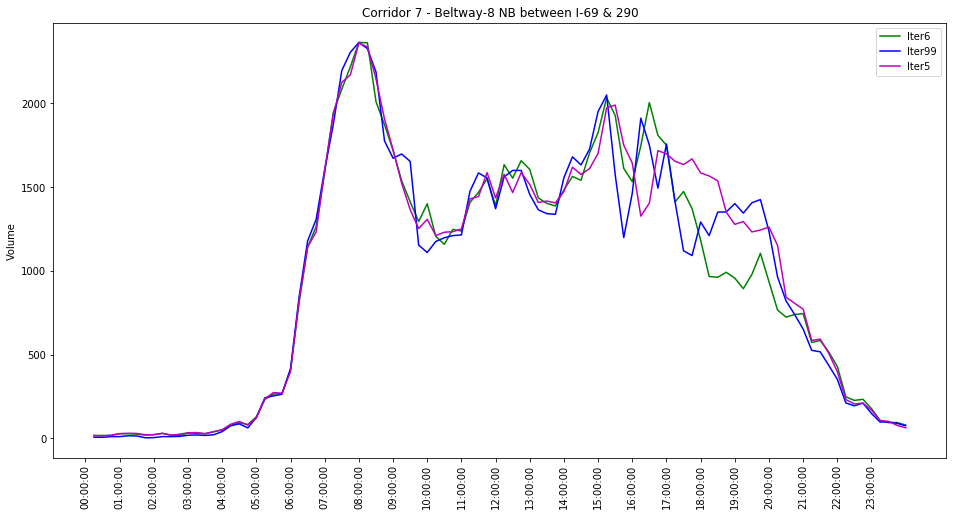

In [42]:
location = 'Corridor 7 - Beltway-8 NB between I-69 & 290'
nodes = [(212536, 212531)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


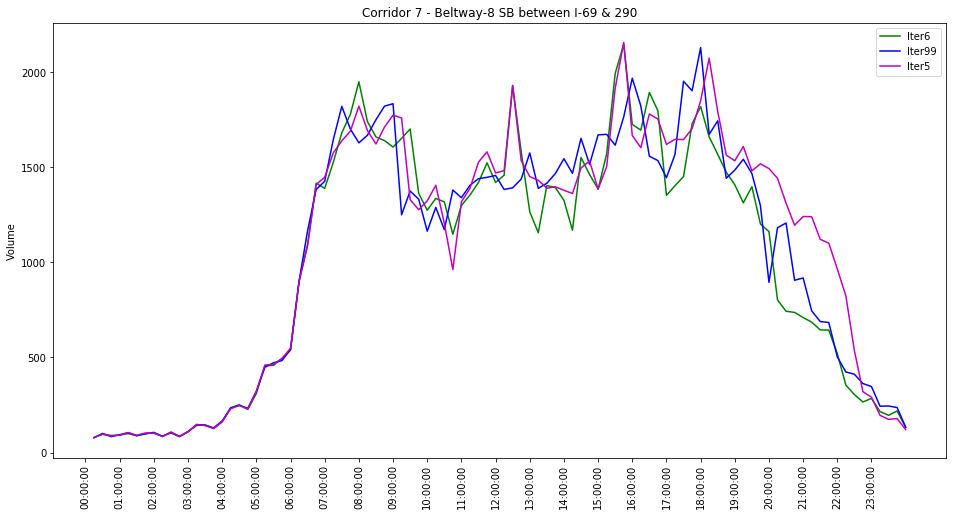

In [43]:
location = 'Corridor 7 - Beltway-8 SB between I-69 & 290'
nodes = [(214956, 214957)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


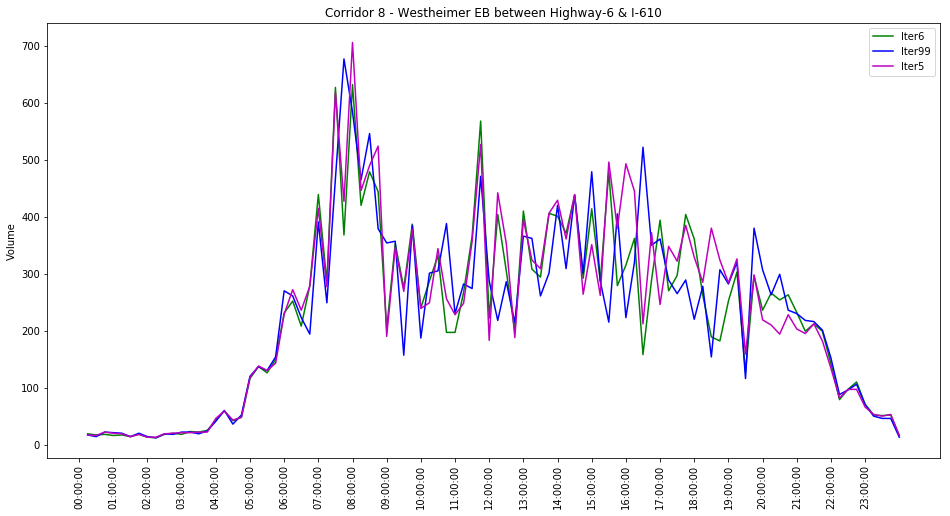

In [44]:
location = 'Corridor 8 - Westheimer EB between Highway-6 & I-610'
nodes = [(28304, 28300)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')

Number of observations for Measure 0 = 96
Number of observations for Measure 1 = 96
Number of observations for Measure 2 = 96


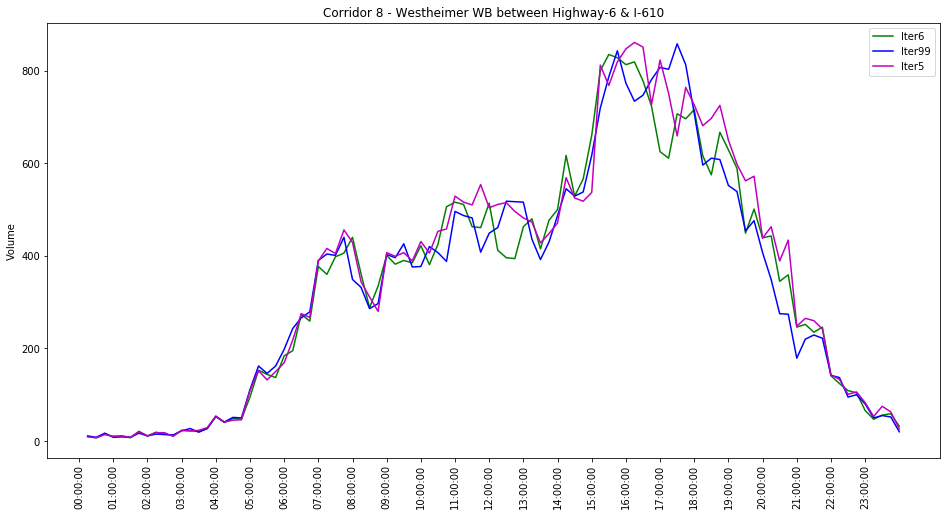

In [45]:
location = 'Corridor 8 - Westheimer WB between Highway-6 & I-610'
nodes = [(75607, 75608)]*3
names = 'Iter6', 'Iter99', 'Iter5'
ax = compare_profiles(dfs,nodes,names, location, simulation_interval, measure_name=measure_name)
plt.savefig(os.path.join(FIGURE_FOLDER, location + ' ' + measure_name + '.png'), dpi=150, format='png')